# Rice Image Classification using SVM and Random Forest

## Importing Dependencies

In [68]:
from tensorflow.keras.utils import to_categorical
from skimage import feature
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.image as mpimg
from joblib import dump
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import Image
import random

## Image Loading and Pre processing

In [25]:
dataset_path = r"C:\Users\ramee\Downloads\Rice Dataset\Rice_Image_Dataset"
CATEGORIES = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
IMG_SIZE = 200
MAX_IMAGES_PER_CLASS = 3000  # Limit the number of images per class

training = []

def TrainingData():
    for i, category in enumerate(CATEGORIES):
        path = os.path.join(dataset_path, category)
        print(path)
        class_num = i  # Use the index of the category as the class number
        
        image_count = 0  # Keep track of the number of images collected for this class
        for img in os.listdir(path):
            if image_count >= MAX_IMAGES_PER_CLASS:
                break  # Stop collecting images once the limit is reached
            
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training.append([new_array, class_num])
            image_count += 1

# Call the TrainingData() function to process the dataset
TrainingData()

C:\Users\ramee\Downloads\Rice Dataset\Rice_Image_Dataset\Arborio
C:\Users\ramee\Downloads\Rice Dataset\Rice_Image_Dataset\Basmati
C:\Users\ramee\Downloads\Rice Dataset\Rice_Image_Dataset\Ipsala
C:\Users\ramee\Downloads\Rice Dataset\Rice_Image_Dataset\Jasmine
C:\Users\ramee\Downloads\Rice Dataset\Rice_Image_Dataset\Karacadag


In [26]:
len(training)

15000

## Viewing some of the rice images

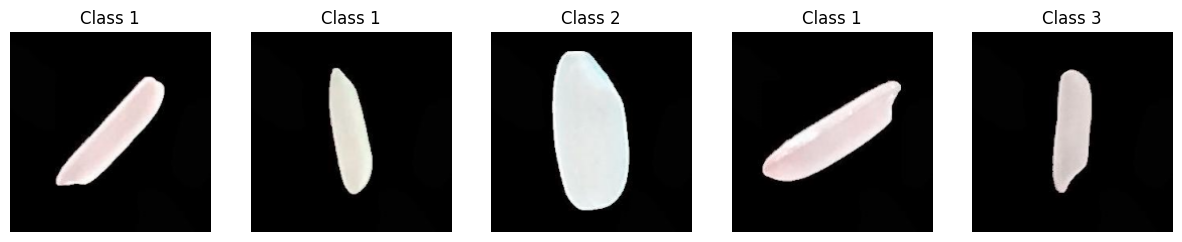

In [49]:
import random

# Display 5 random sample images from different rice varieties
num_samples = 5
fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    random_index = random.randint(0, len(training) - 1)
    sample_image = training[random_index][0]
    sample_class = training[random_index][1]
    
    axs[i].imshow(sample_image.squeeze(), cmap='gray')  # Assuming grayscale images
    axs[i].axis('off')
    axs[i].set_title(f"Class {sample_class}")

plt.show()


## Splitting the image and label

In [50]:
random.shuffle(training)

In [51]:
X =[]
y =[]
for features, label in training:
  X.append(features)
  y.append(label)
#converting the list to an numpy array
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

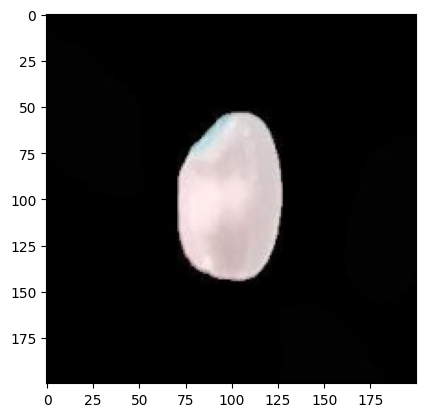

In [52]:
#plotting one image from the variable X
plt.imshow(X[0])
plt.show()

## One Hot Encoding

In [57]:
# Assuming y contains labels with values 0, 1, 2, 3, and 4 for the 5 categories
Y = to_categorical(y, num_classes=5)

# Print a sample categorical label
print(Y[1])


[0. 0. 0. 0. 1.]


## Extracting Local Binary Pattern from the dataset

In [58]:
def extract_lbp_features(image):
    lbp_radius = 1
    lbp_points = 8 * lbp_radius

    # Ensure the image is in the range [0, 1]
    image = image.astype(np.float32)
    
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Extract LBP features
    lbp = feature.local_binary_pattern(gray_image, lbp_points, lbp_radius, method='uniform')
    
    # Resize LBP features to the same size as the input image (200x200)
    lbp_resized = cv2.resize(lbp, (200, 200), interpolation=cv2.INTER_LINEAR)

    return lbp_resized

In [69]:
X_lbp = []
for image in X:
    temp = extract_lbp_features(image)
    X_lbp.append(temp)

D:\Jupyter\data science project\genderClassification\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [70]:
len(X_lbp)

15000

In [71]:
print(X_lbp[1])
lbp_radius = 1
lbp_points = 8 * lbp_radius

[[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]


In [72]:
lbp_vis = X_lbp[1].astype(np.uint8) * (255 / (lbp_points + 2))

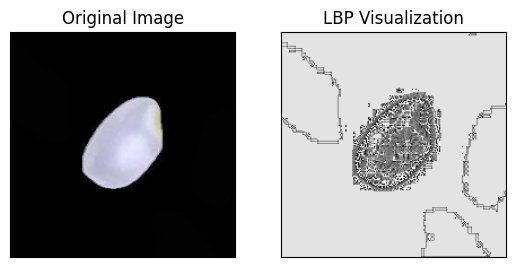

In [73]:
plt.subplot(121), plt.imshow(cv2.cvtColor(X[1], cv2.COLOR_BGR2RGB), cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(lbp_vis, cmap='gray')
plt.title('LBP Visualization'), plt.xticks([]), plt.yticks([])
plt.show()

## Train Test Split

In [74]:
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = train_test_split(X_lbp, y, test_size = 0.2, random_state = 3)

In [75]:
X_train_lbp = np.array(X_train_lbp)
X_test_lbp = np.array(X_test_lbp)
y_train_lbp = np.array(y_train_lbp)
y_test_lbp = np.array(y_test_lbp)

(200, 200)


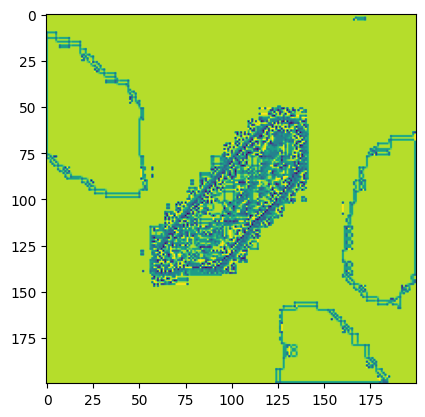

3


In [76]:
print(X_test_lbp[1].shape)
plt.imshow(X_test_lbp[1])  
plt.show()
print(y_test_lbp[1])

In [77]:
X_train_lbp = X_train_lbp.reshape((X_train_lbp.shape[0],200*200))
X_test_lbp = X_test_lbp.reshape((X_test_lbp.shape[0],200*200))

## SVM and Random forest model

In [78]:
# Create and train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train_lbp, y_train_lbp)

# Create and train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_lbp, y_train_lbp)

# Predict the class using SVM
svm_prediction = svm_classifier.predict(X_test_lbp)

# Predict the class using Random Forest
rf_prediction = rf_classifier.predict(X_test_lbp)

print("SVM Predictions:", svm_prediction)
print("Random Forest Predictions:", rf_prediction)

SVM Predictions: [1 3 4 ... 0 2 2]
Random Forest Predictions: [1 3 0 ... 0 2 2]


## Saving the Model for future use

In [85]:
# Save the SVM model
dump(svm_classifier, 'svm_model.joblib')

# Save the Random Forest model
dump(rf_classifier, 'random_forest_model.joblib')

['random_forest_model.joblib']

## Model Evaluation for SVM

In [86]:
svm_accuracy = accuracy_score(y_test_lbp, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.975


In [88]:
# Classification Report for SVM
svm_report = classification_report(y_test_lbp, svm_prediction)
print("Classification Report - SVM:\n", svm_report)

Classification Report - SVM:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       590
           1       0.97      0.98      0.97       608
           2       1.00      0.99      0.99       626
           3       0.96      0.96      0.96       575
           4       0.97      0.99      0.98       601

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.98      0.97      0.97      3000



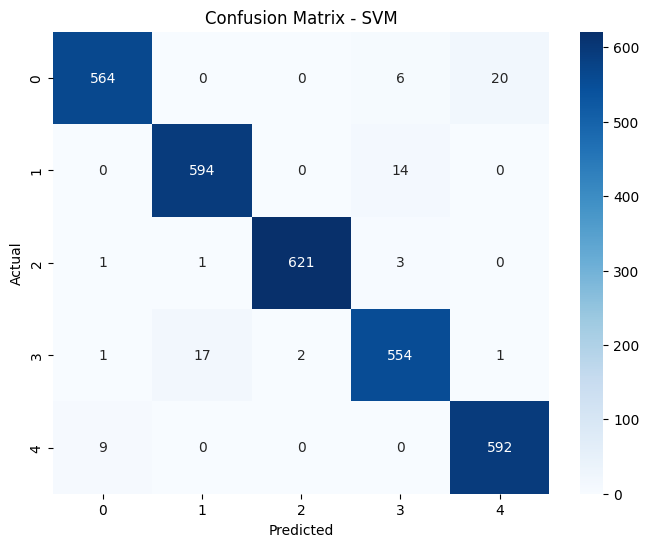

In [94]:
# Confusion Matrix for SVM
svm_cm = confusion_matrix(y_test_lbp, svm_prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Model Evaluation for Random Forest

In [87]:
rf_accuracy = accuracy_score(y_test_lbp, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.9526666666666667


In [91]:
rf_report = classification_report(y_test_lbp, rf_prediction)
print("Classification Report - Random Forest:\n", rf_report)

Classification Report - Random Forest:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       590
           1       0.94      0.99      0.96       608
           2       0.99      1.00      0.99       626
           3       0.97      0.91      0.94       575
           4       0.93      0.95      0.94       601

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



In [97]:
rf_cm

array([[537,   0,   0,   8,  45],
       [  0, 603,   0,   5,   0],
       [  0,   0, 623,   3,   0],
       [  3,  41,   7, 523,   1],
       [ 29,   0,   0,   0, 572]], dtype=int64)

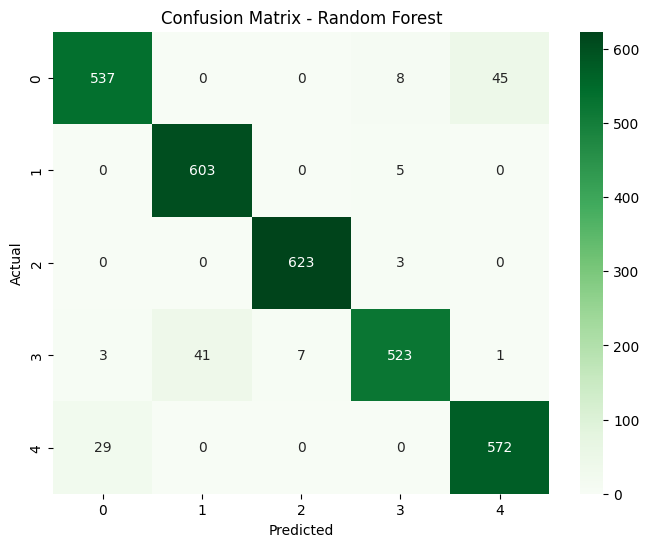

In [95]:
rf_cm = confusion_matrix(y_test_lbp, rf_prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Greens", cbar=True)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()